# Parkinson's Disease Progression Estimation by Noninvasive Speech Tests

<b>By Elyas Shaswary, PhD </b>

Parkinson's disease (PD) is the second most common neurodgeneartive disorder after Alzheimer's, which profoundly affect people's life. It is estimated that more then one million people in North America alone are affected. 

Management of PD typically involves the administration of physical examinations applying various empirical tests, including speech and voice tests, with a medical rater subjectively assessing the subject’s ability to perform a range of tasks. However, the necessity for the development of reliable, objective tools for assessing PD is manifested in the fact that current diagnosis is poor and autopsy studies are reportedly inaccurate.

Physical test observations are mapped to a metric specifically designed to follow disease progression, typically the unified Parkinson’s disease rating scale (UPDRS) that reflects the presence and severity of symptoms (but does not quantify their underlying causes). For untreated patients, it spans the range
0–176, with 0 representing healthy state and 176 representing total disabilities, and consists of three sections: 1) mentation, behavior, and mood; 2) activities of daily living; and 3) motor. The motor UPDRS ranges from 0 to 108, with 0 denoting symptom free and 108 denoting severe motor impairment, and encompasses tasks such as speech, facial expression, tremor, and rigidity. Speech has two explicit headings and ranges between 0 and 8 with 8 being unintelligible.

Noninvasive telemonitoring is an emerging option, in general, medical care, potentially affording reliable, cost-effective screening of PWP, alleviating the burden of frequent and often inconvenient visits to the clinic. This also relieves national health systems from excessive additional workload, decreasing the cost and increasing the accuracy of clinical evaluation of the subject’s condition.

Intel Corporation’s at-home testing device (AHTD) is a novel telemonitoring system facilitating remote, Internet-enabled measurement of a range of PD-related motor impairment symptoms. It records both manual dexterity and speech tests; in this study, only the sustained vowel phonations was focused on.

A range of features from speech signal was extracted that was used to establish a relationship between speech signal properties and UPDRS.


For more details about the original study click <a href="https://ieeexplore.ieee.org/document/5339170/"> here</a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)
import scipy.stats as stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

from skopt import BayesSearchCV
from skopt import gp_minimize

# for the analysis
from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
import optuna

import os
import random
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(1234)

## Dataset

In [3]:
'''
A. Tsanas, M. A. Little, P. E. McSharry and L. O. Ramig, "Accurate Telemonitoring of Parkinson's Disease Progression 
by Noninvasive Speech Tests," in IEEE Transactions on Biomedical Engineering, vol. 57, no. 4, pp. 884-893, April 2010, 
doi: 10.1109/TBME.2009.2036000.

Article: https://ieeexplore.ieee.org/document/5339170
Dataset: https://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring

-------------------------------------------------------------------------------------------------------------
ATTRIBUTE INFORMATION:

subject# - Integer that uniquely identifies each subject
age - Subject age
sex - Subject gender '0' - male, '1' - female
test_time - Time since recruitment into the trial. The integer part is the number of days since recruitment.
motor_UPDRS - Clinician's motor UPDRS score, linearly interpolated
total_UPDRS - Clinician's total UPDRS score, linearly interpolated
Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP - Several measures of variation in fundamental frequency
Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11, Shimmer:DDA - Several measures of variation in amplitude
NHR, HNR - Two measures of ratio of noise to tonal components in the voice
RPDE - A nonlinear dynamical complexity measure
DFA - Signal fractal scaling exponent
PPE - A nonlinear measure of fundamental frequency variation 
-------------------------------------------------------------------------------------------------------------

'''

# dataset = pd.read_csv('/content/drive/MyDrive/datasets/parkinsons/parkinsons_updrs.data')
dataset = pd.read_csv('parkinsons_updrs.data')
dataset.head(10)

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
5,1,72,0,40.6520,29.435,36.870,0.00353,0.000023,0.00119,0.00159,...,0.214,0.01006,0.01337,0.02263,0.03019,0.009438,22.946,0.53949,0.57243,0.19500
6,1,72,0,47.6490,29.682,37.363,0.00422,0.000024,0.00212,0.00221,...,0.445,0.02376,0.02621,0.03488,0.07128,0.013260,22.506,0.49250,0.54779,0.17563
7,1,72,0,54.6400,29.928,37.857,0.00476,0.000025,0.00226,0.00259,...,0.212,0.00979,0.01462,0.01911,0.02937,0.027969,22.929,0.47712,0.54234,0.23844
8,1,72,0,61.6690,30.177,38.353,0.00432,0.000029,0.00156,0.00207,...,0.371,0.01774,0.02134,0.03451,0.05323,0.013381,22.078,0.51563,0.61864,0.20037
9,1,72,0,68.6880,30.424,38.849,0.00496,0.000027,0.00258,0.00253,...,0.310,0.02030,0.01970,0.02569,0.06089,0.018021,22.606,0.50032,0.58673,0.20117


In [4]:
# size of dataset
dataset.shape

(5875, 22)

# Exploratory Data Analysis

### Variable Types

In [5]:
# check the type of data stored in each column
dataset.dtypes

subject#           int64
age                int64
sex                int64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object

### Missing Data

In [6]:
# check for missing data
dataset.isnull().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

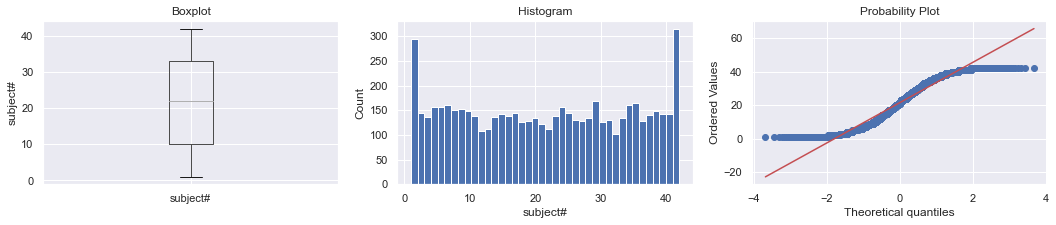

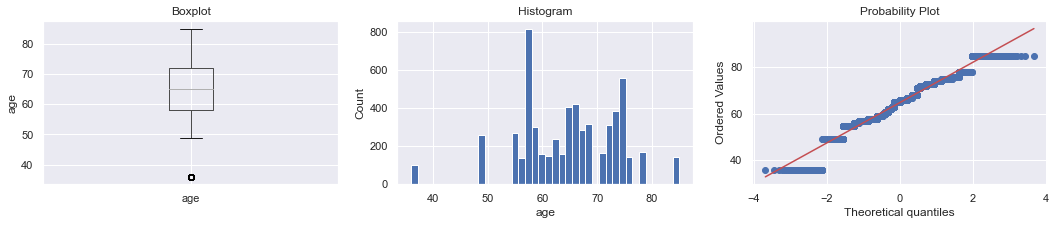

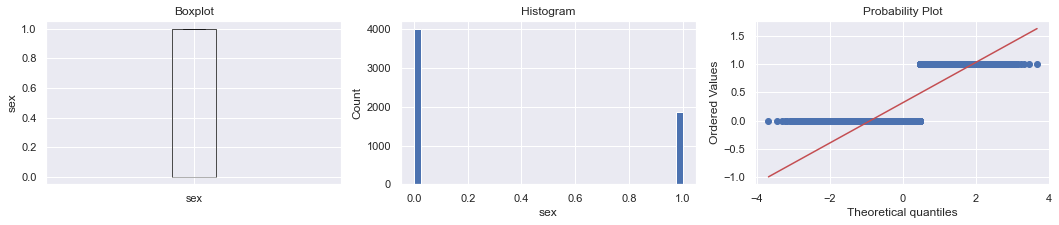

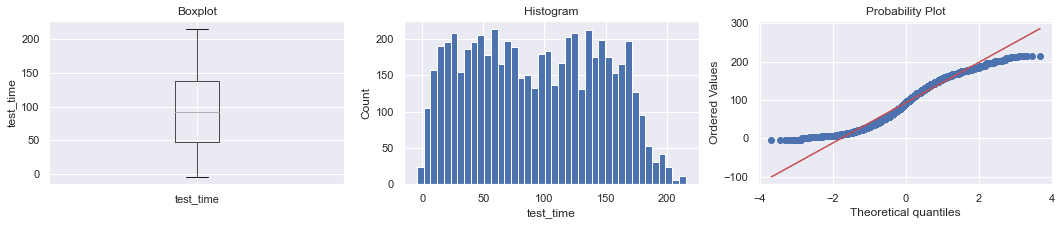

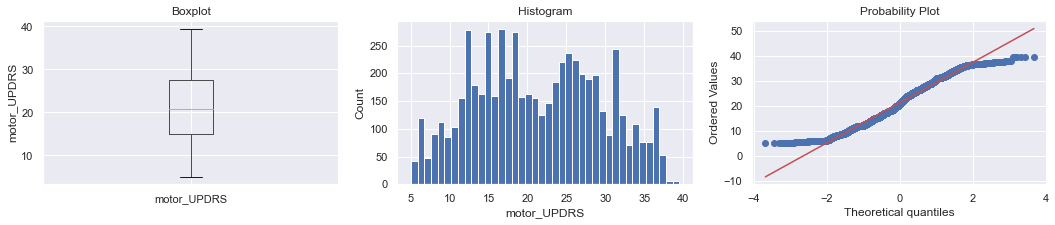

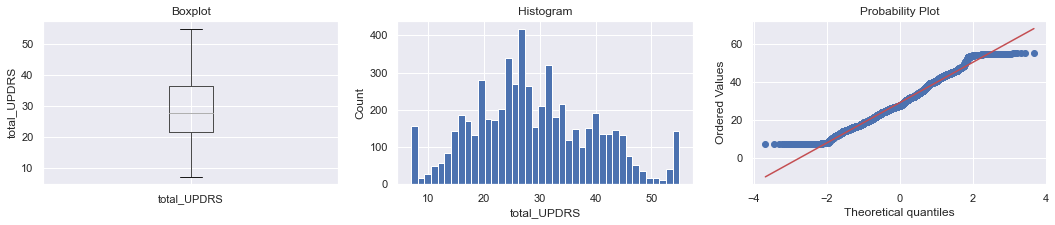

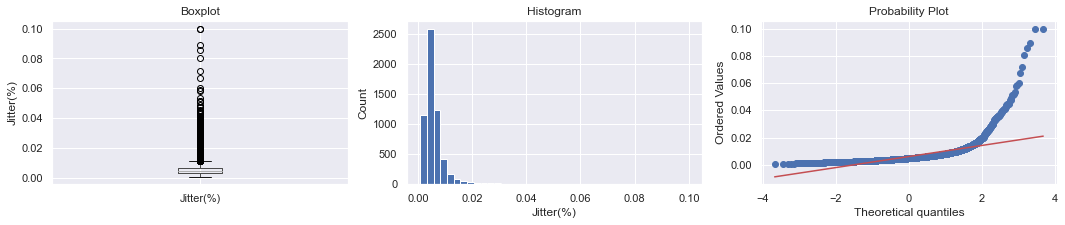

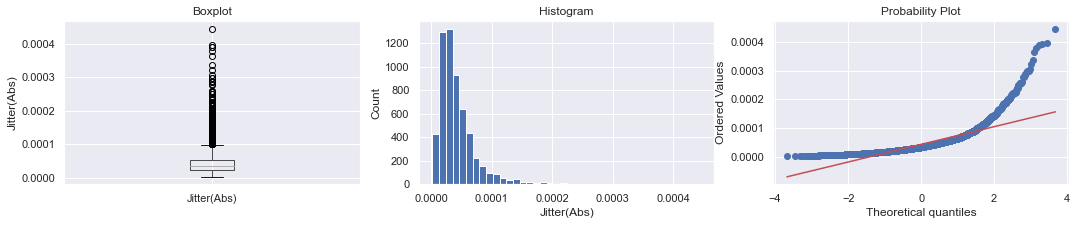

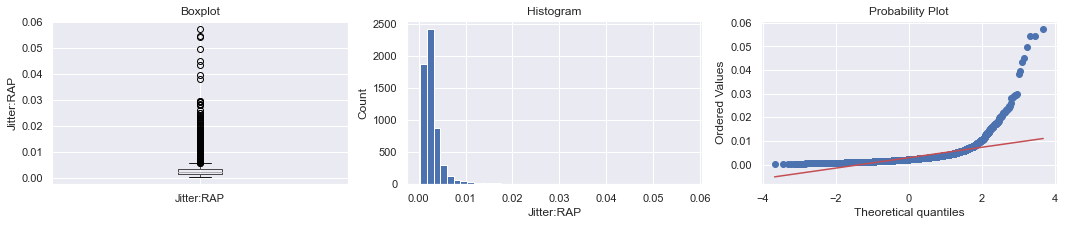

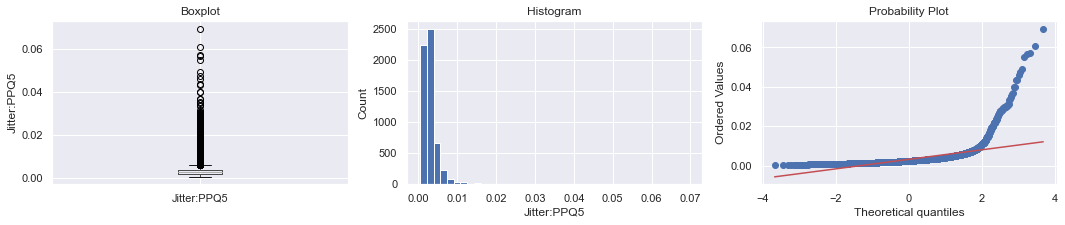

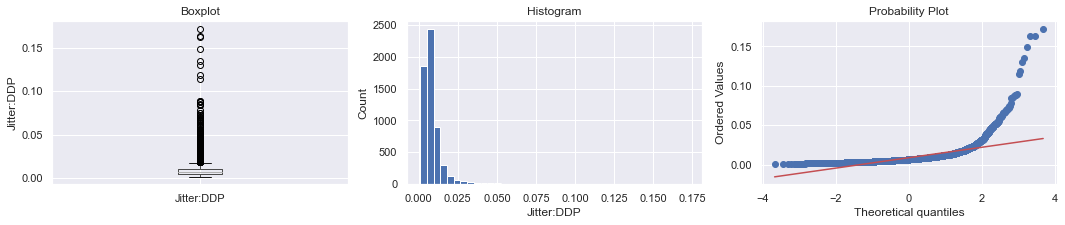

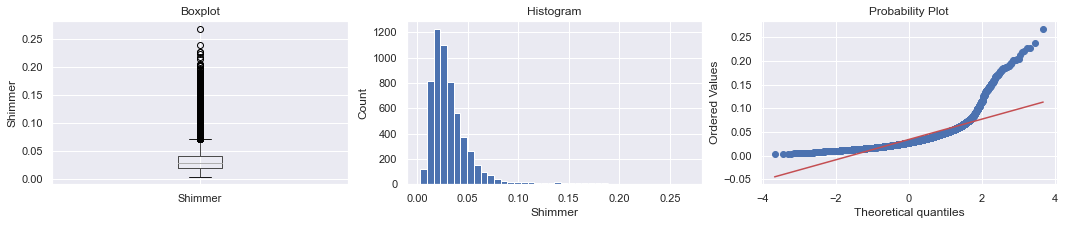

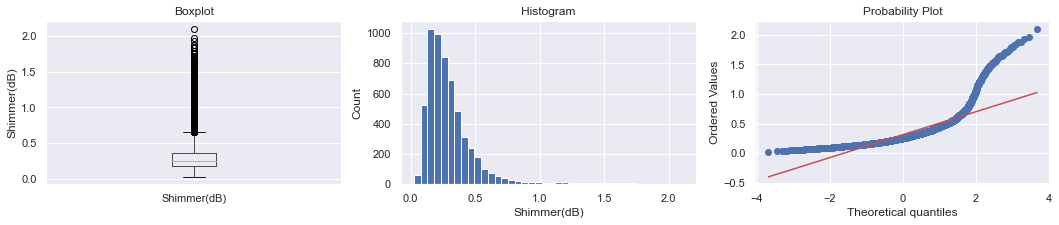

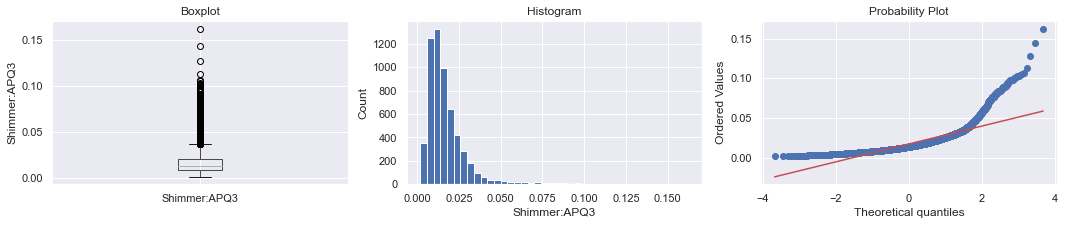

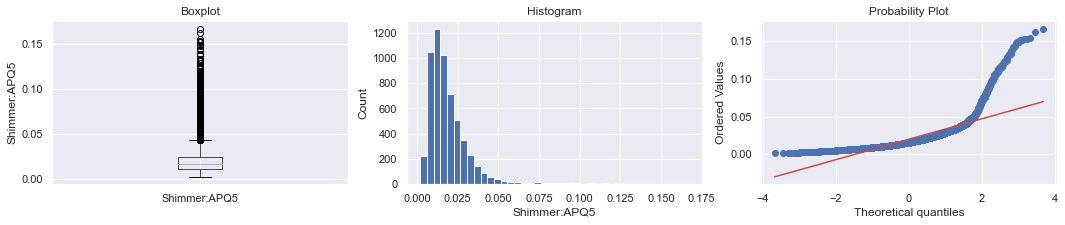

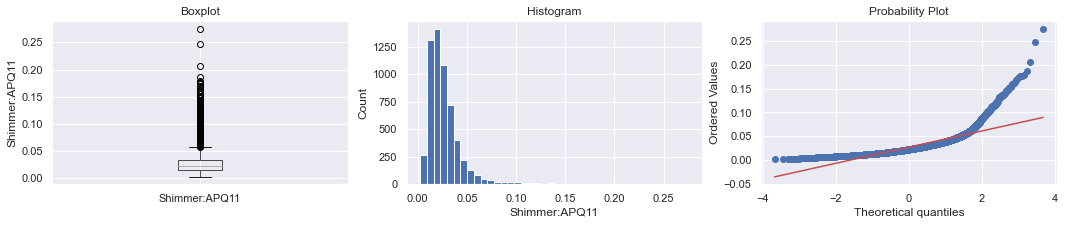

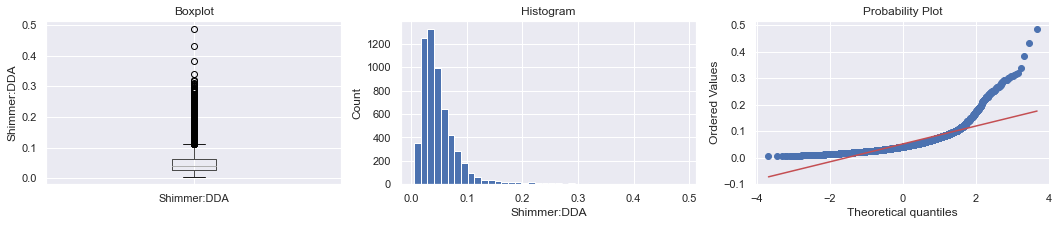

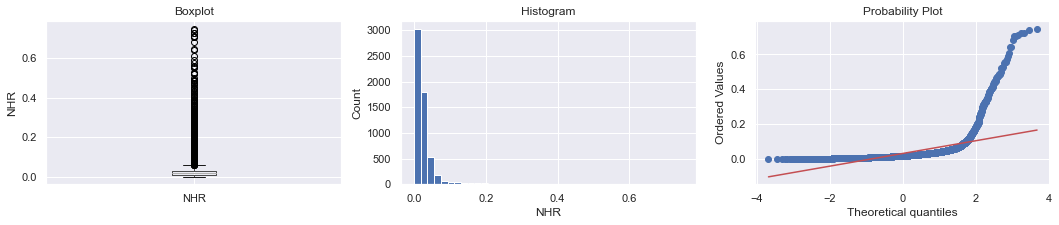

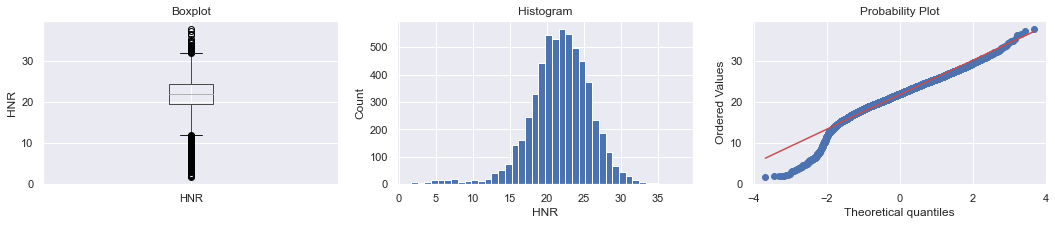

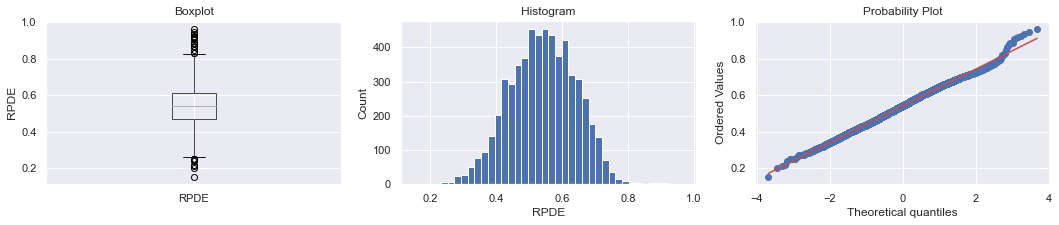

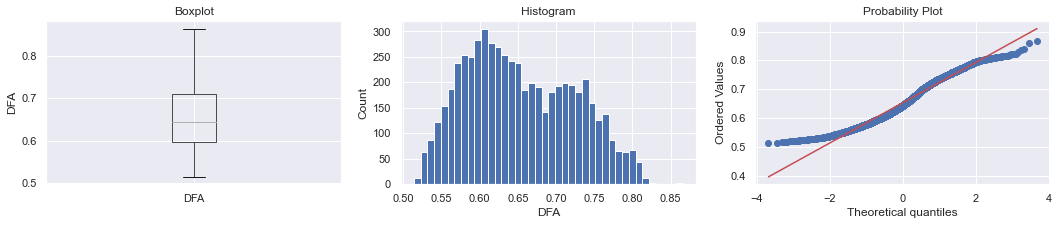

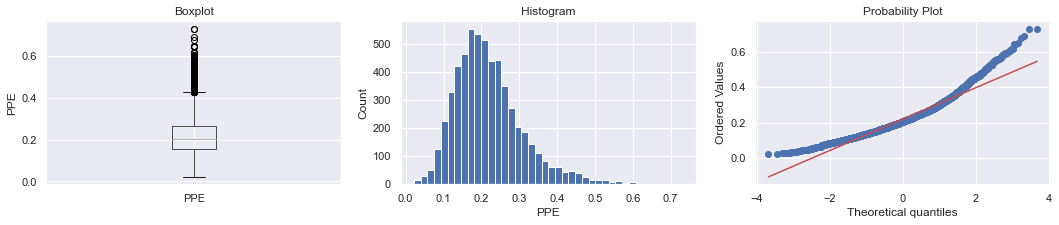

In [7]:
# make boxplots to visualise outliers in the variables, histograms to get an idea of the distribution,
# Q-Q (or probability) plot to check if variable is normally distributed.
# Q-Q plot, is an easy way to visually compare an empirical distribution of data against a theoretical 
# distribution. This is essentially a scatter plot of observed versus theoretical quantiles.

for var in dataset.columns:
    plt.figure(figsize=(18,3))
    plt.subplot(1, 3, 1)
    fig = dataset.boxplot(column=var)
    fig.set_title('Boxplot')
    fig.set_ylabel(var)

    plt.subplot(1, 3, 2)
    fig = dataset[var].hist(bins=40)
    fig.set_title('Histogram')
    fig.set_ylabel('Count')
    fig.set_xlabel(var)

    plt.subplot(1, 3, 3)
    stats.probplot(dataset[var], dist="norm", plot=plt)

    plt.show()

Several variables contain outliers and are not normallly distributed. 

### Target Variables

There are two target variables. So we examine the relationship between them. 

We evaluate linear model assumption between the two target variables by scatter plot and residual plots.

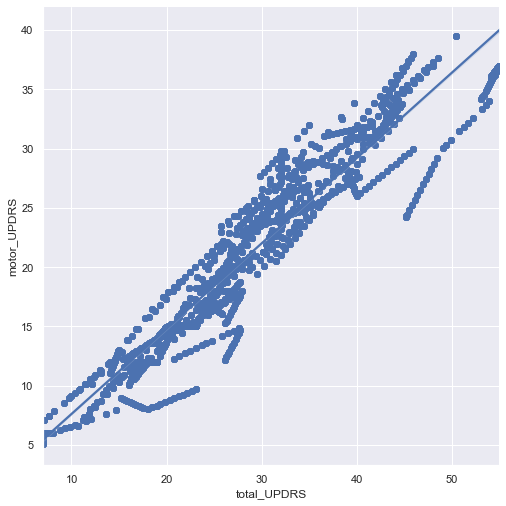

In [8]:
sns.lmplot(x="total_UPDRS", y="motor_UPDRS", data=dataset, order=1, height=7, aspect=1) # order 1 indicates linear model

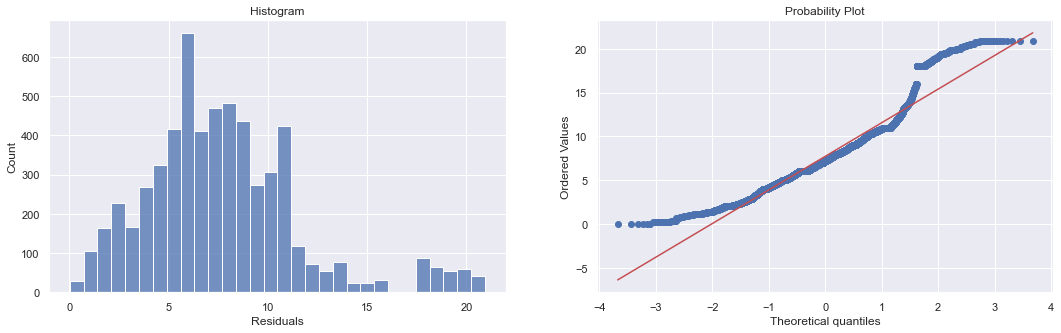

Correlation coefficent between the two target variables is 94.72%


In [9]:
residuals_updrs = dataset['total_UPDRS'] - dataset['motor_UPDRS']
# residuals_updrs = residuals_updrs- np.mean(residuals_updrs)

plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
# make a histogram to determine if the residuals are normally distributed with mean value at 0
sns.histplot(residuals_updrs, bins=30);
plt.xlabel('Residuals')
plt.title('Histogram')

plt.subplot(1, 2, 2)
# we can better visualize residual distribution with a Q-Q plot. 
# If the residuals are normally distributed the dots should adjust to the 45 degree line
stats.probplot(residuals_updrs, dist="norm", plot=plt);
plt.show()

print('Correlation coefficent between the two target variables is {:.2f}%'.format(dataset['total_UPDRS'].corr(dataset['motor_UPDRS'])*100) )

The target variable seems to be linearly correlated with each other and their resdual is somewhat normally distributed. 

Thus, either one of target variables can be used to train a model. 

## Feature Engineering

In [10]:
# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS'], axis=1),
                                                    dataset['motor_UPDRS'],
                                                    test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape
X_train.head()

,age,sex,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
598,75,0,0.00493,0.000041,0.00214,0.00278,0.00643,0.04291,0.368,0.02268,0.02892,0.04076,0.06803,0.026969,17.304,0.59679,0.66536,0.23970
4511,66,1,0.00330,0.000010,0.00158,0.00153,0.00475,0.02274,0.229,0.01200,0.01291,0.01825,0.03600,0.021930,20.407,0.50141,0.52669,0.23438
5284,66,0,0.02251,0.000219,0.01262,0.00902,0.03785,0.05579,0.538,0.02656,0.03037,0.03621,0.07967,0.129720,16.021,0.72480,0.62491,0.35762
1431,58,0,0.01150,0.000105,0.00462,0.00581,0.01387,0.03020,0.404,0.01567,0.01755,0.02216,0.04702,0.031666,20.433,0.55557,0.67689,0.31261
3582,49,0,0.00603,0.000045,0.00309,0.00307,0.00928,0.10820,0.936,0.06262,0.06365,0.07062,0.18786,0.033073,16.860,0.56374,0.70793,0.24890


<AxesSubplot:>

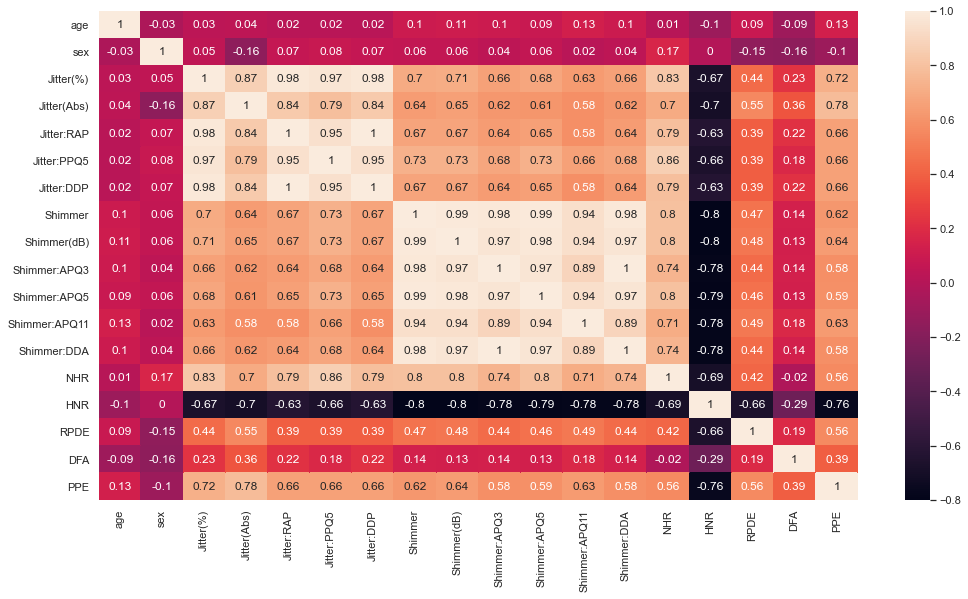

In [11]:
# to determine co-linearity, we evaluate the correlation of all the independent variables in the dataframe.

correlation_matrix = X_train.corr().round(2)
figure = plt.figure(figsize=(17, 9))
sns.heatmap(data=correlation_matrix, annot=True)

There are two groups of highly correlated features. 

In [12]:
# check and remove constant features
constant_features = [feat for feat in X_train.columns if X_train[feat].std() == 0]
print('There were {} contant features'.format(len(constant_features)))

if len(constant_features)>0:
    X_train.drop(labels=constant_features, axis=1, inplace=True)
    X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

There were 0 contant features


((4700, 18), (1175, 18))

There were no constant features.

In [13]:
# find and remove correlated features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.85)
print('correlated features: ', len(set(corr_features)) )

correlated features:  10


There are 10 correlated features. Features were assumed to be correlated if correlation coefficent between them was greater than 85%.

In [14]:
# list correlated features
corr_features

{'Jitter(Abs)',
 'Jitter:DDP',
 'Jitter:PPQ5',
 'Jitter:RAP',
 'NHR',
 'Shimmer(dB)',
 'Shimmer:APQ11',
 'Shimmer:APQ3',
 'Shimmer:APQ5',
 'Shimmer:DDA'}

In [15]:
# remove correlated features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((4700, 8), (1175, 8))

Out of the 18 features, 10 features were removed since they were higly correlated with other features. 

In [16]:
X_train.head()

,age,sex,Jitter(%),Shimmer,HNR,RPDE,DFA,PPE
598,75,0,0.00493,0.04291,17.304,0.59679,0.66536,0.23970
4511,66,1,0.00330,0.02274,20.407,0.50141,0.52669,0.23438
5284,66,0,0.02251,0.05579,16.021,0.72480,0.62491,0.35762
1431,58,0,0.01150,0.03020,20.433,0.55557,0.67689,0.31261
3582,49,0,0.00603,0.10820,16.860,0.56374,0.70793,0.24890


## Variable Transformation

Some machine learning models like linear and logistic regression assume that the variables are normally distributed. Often, variables are not normally distributed, but, transforming the variables to map their distribution to a Gaussian distribution may boost the performance of the machine learning algorithm.

If a variable is not normally distributed, it is often possible to find a mathematical transformation to normalise its distribution.

In [17]:
# function to plot histogram, Q-Q, and boxplot of a single variable.

def diagnostic_plots(var, label, title_name=''):
       
    plt.figure(figsize=(17,3.5))
    plt.suptitle(title_name, fontweight="bold")
    plt.subplot(1, 3, 1)
    fig = var.hist(bins=30)
    fig.set_title('Histogram')
    fig.set_ylabel('Count')
    fig.set_xlabel(label)

    plt.subplot(1, 3, 2)
    fig = stats.probplot(var, dist="norm", plot=plt)

    plt.subplot(1, 3, 3)
    fig = plt.boxplot(var, labels=[label])
    plt.title('Boxplot')
    plt.ylabel(label)

    plt.show()

In [18]:
# function to visualize different transformation applied to a single variable.
# it's helpful to determine which transformation closely results in normal distribution.

def show_transformations(df, variable):
    data_t = df[variable]
    diagnostic_plots(data_t, variable, 'Original')

    data_t = np.log(df[variable])
    diagnostic_plots(data_t, variable, 'Logarithmic Transformation')

    data_t = 1 / (df[variable]) 
    diagnostic_plots(data_t, variable, 'Reciprocal Transformation')

    data_t = df[variable]**(1/2) 
    diagnostic_plots(data_t, variable, 'Square Root Transformation')

    data_t = df[variable]**(1/10)
    diagnostic_plots(data_t, variable, 'Exponential Transformation')

    data_t, param = stats.boxcox(df[variable]) 
    diagnostic_plots(pd.Series(data_t), variable, 'Box-Cox Transformation')

    data_t, param = stats.yeojohnson(df[variable]) 
    diagnostic_plots(pd.Series(data_t), variable, 'Yeo-Johnson Transformation')

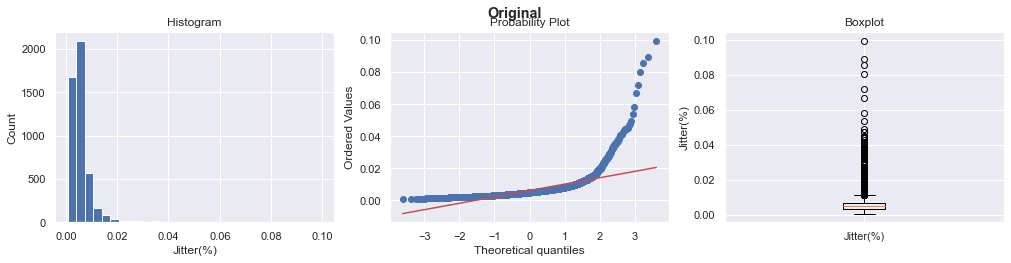

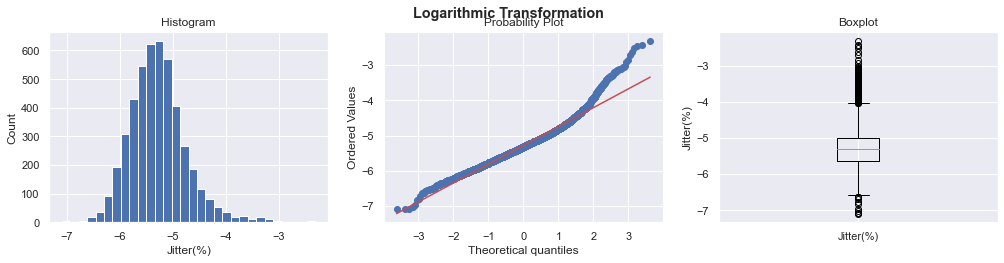

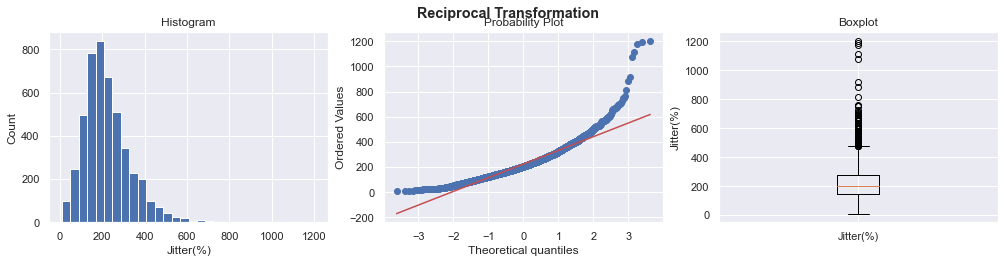

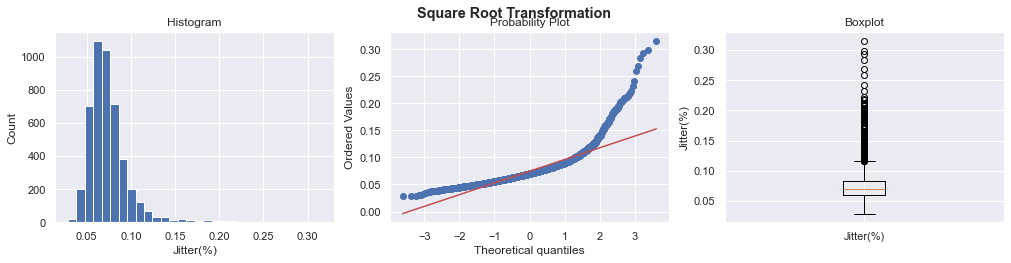

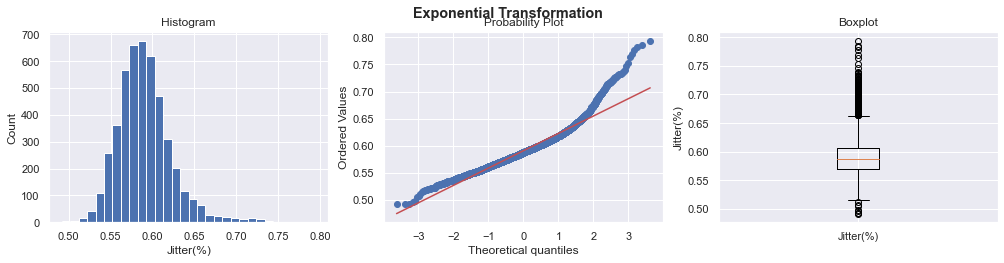

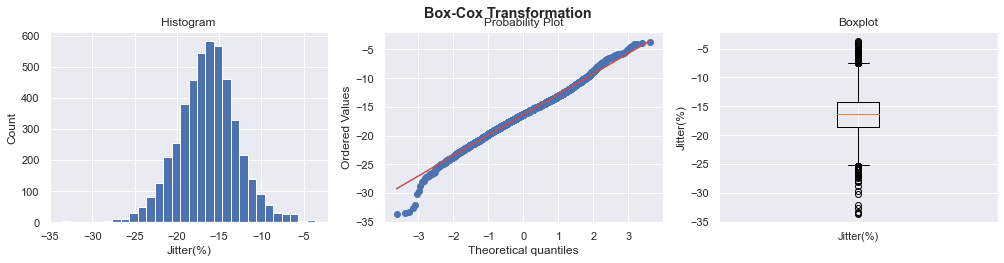

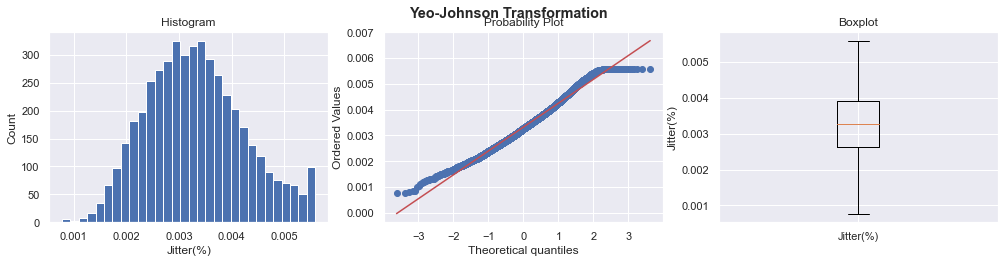

In [19]:
show_transformations(X_train,'Jitter(%)')

It seems that Box-Cox and Yeo-Johnson transformations more closely leads to normal distribution. 
But Yeo-Johnson transformation removes outliers as well. 

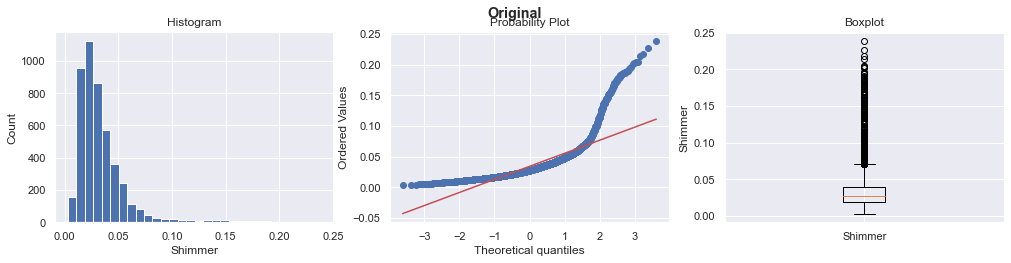

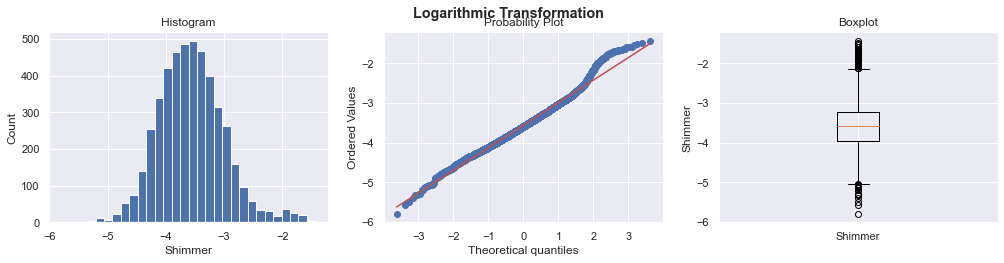

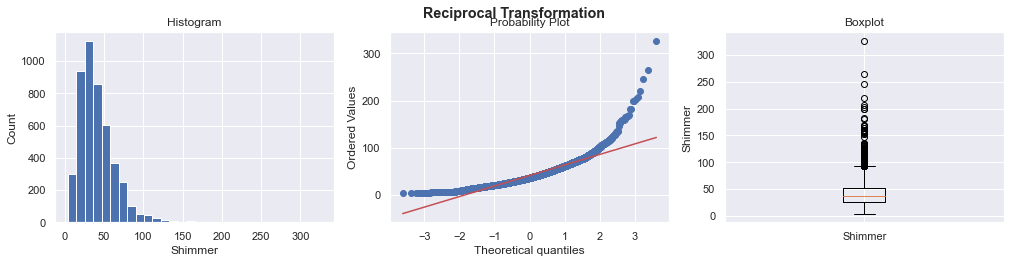

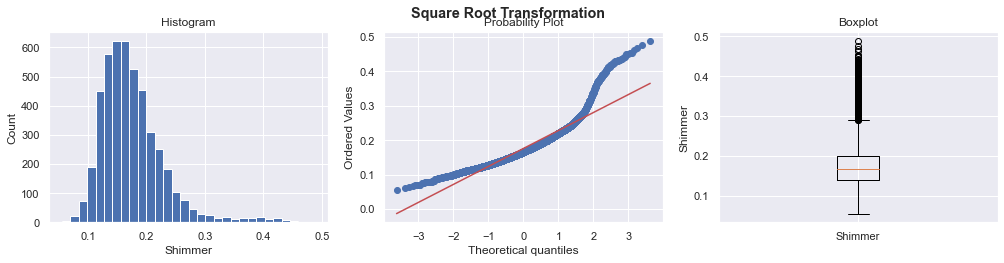

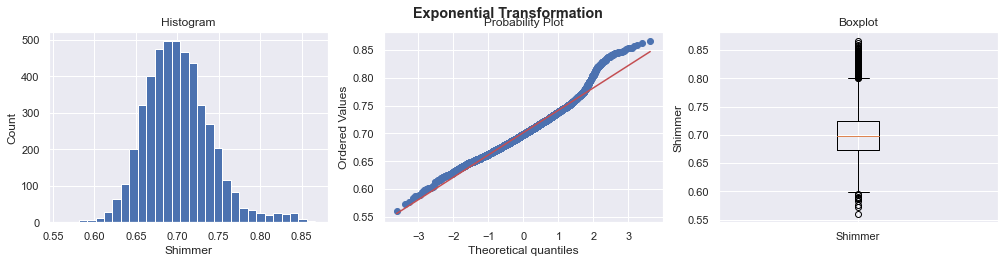

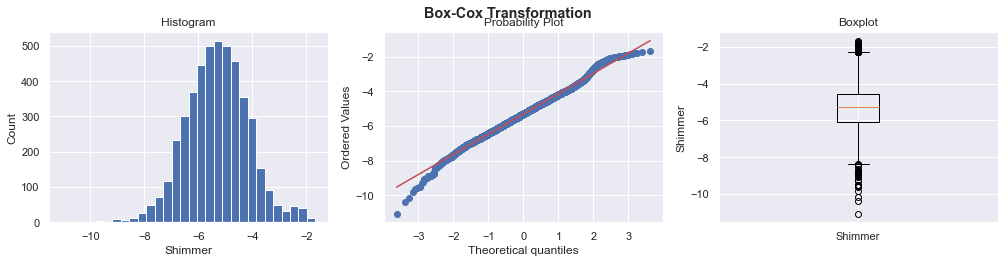

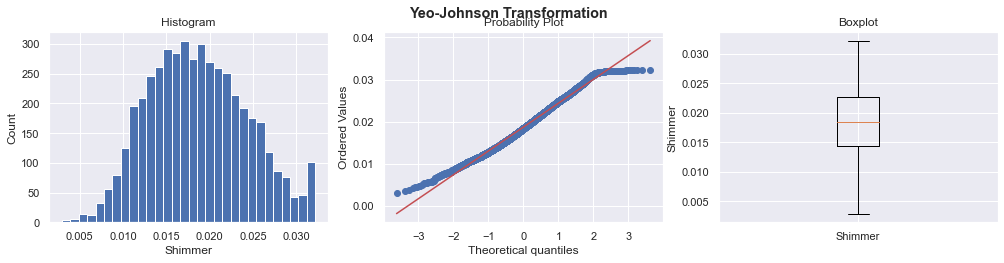

In [20]:
show_transformations(X_train,'Shimmer')

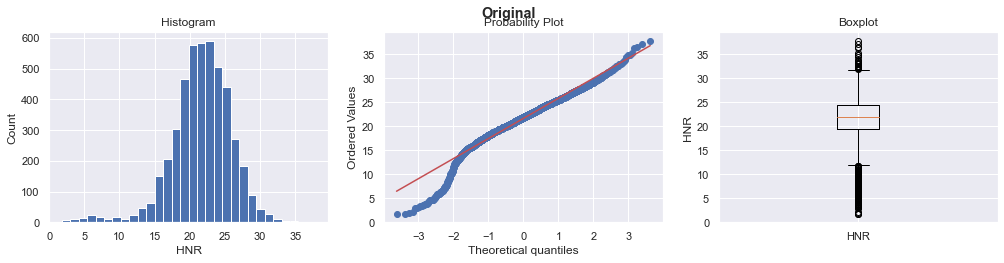

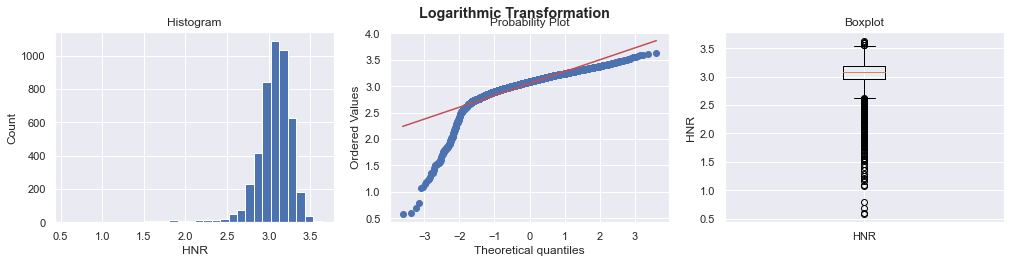

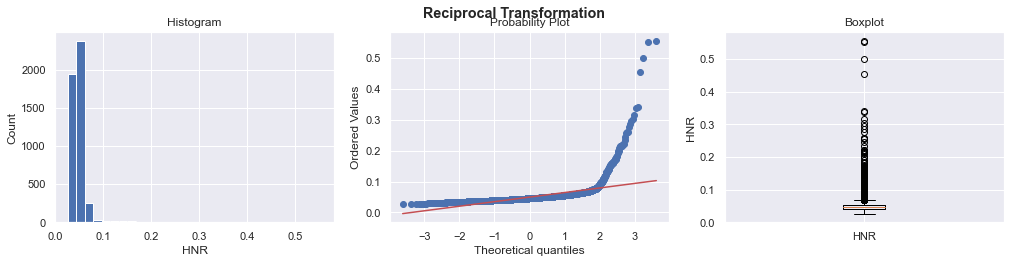

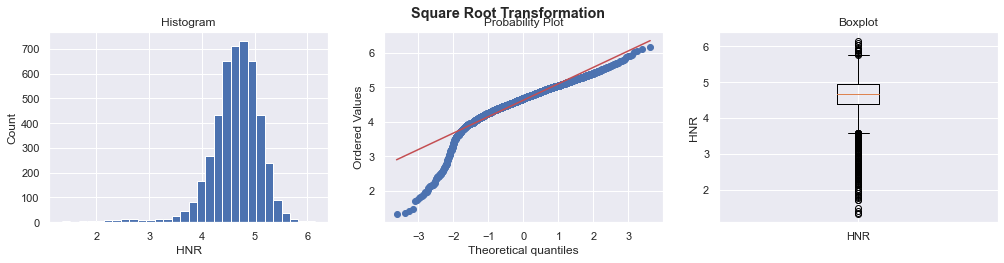

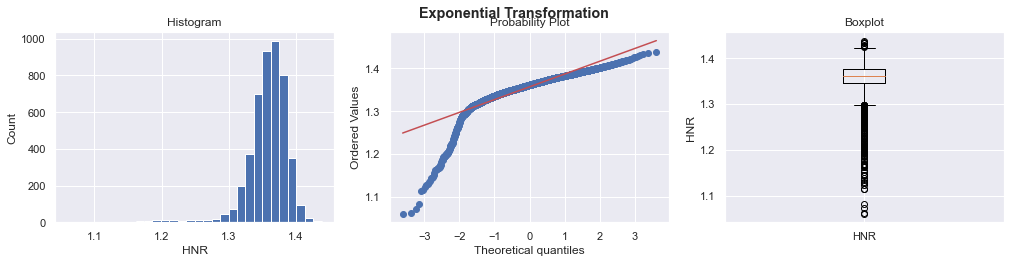

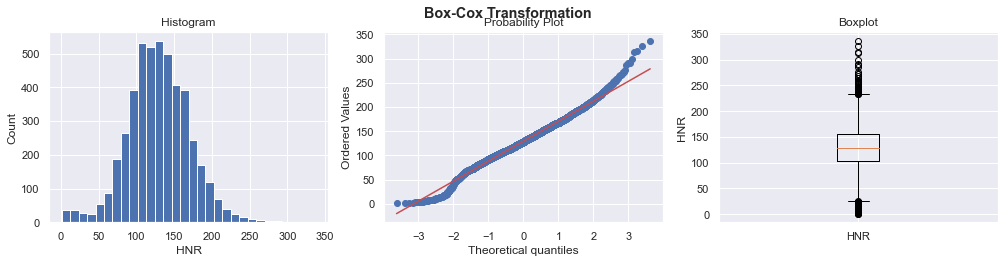

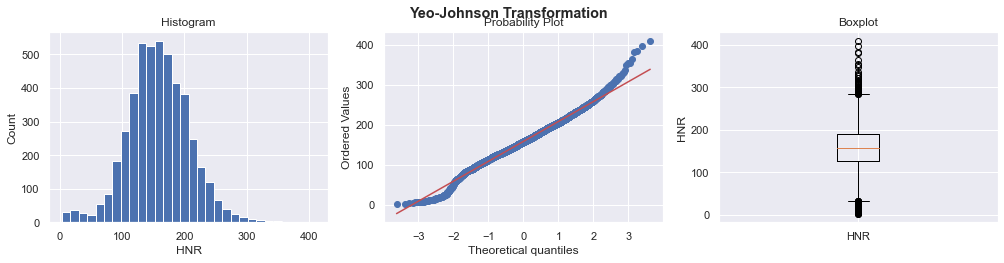

In [21]:
show_transformations(X_train,'HNR')

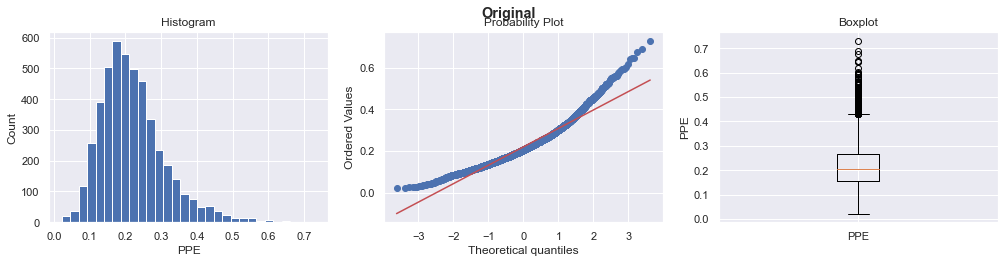

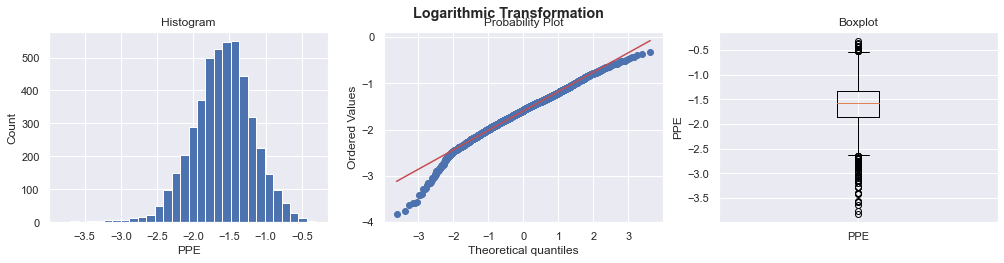

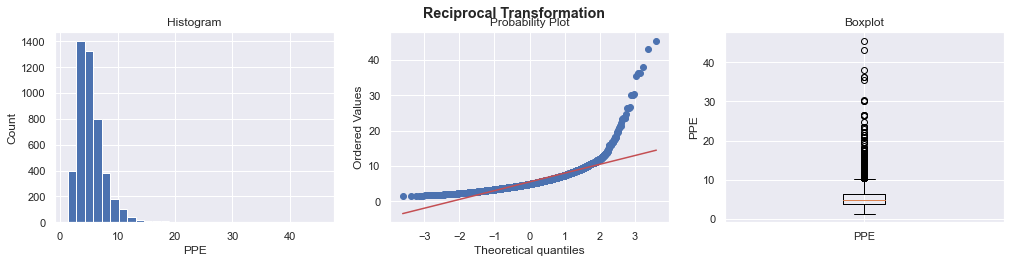

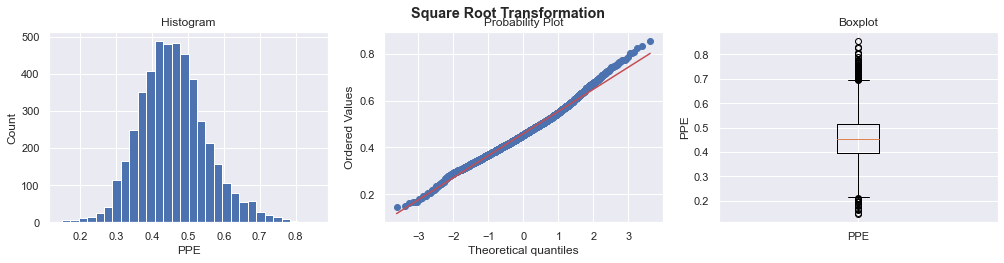

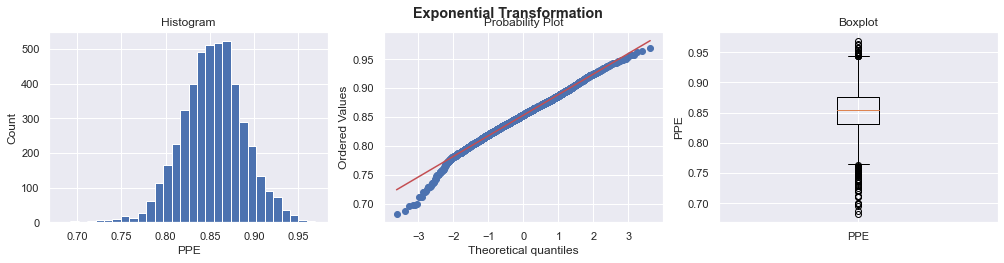

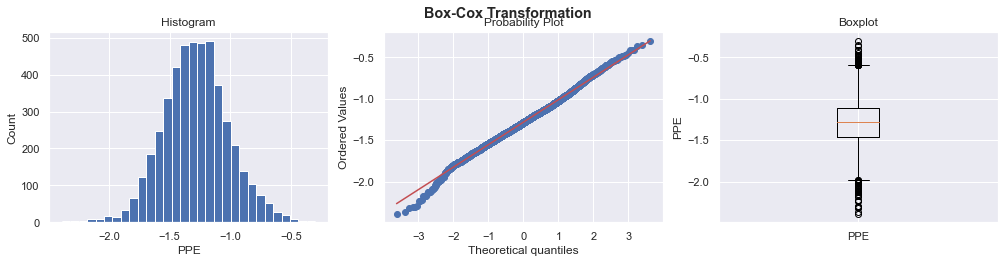

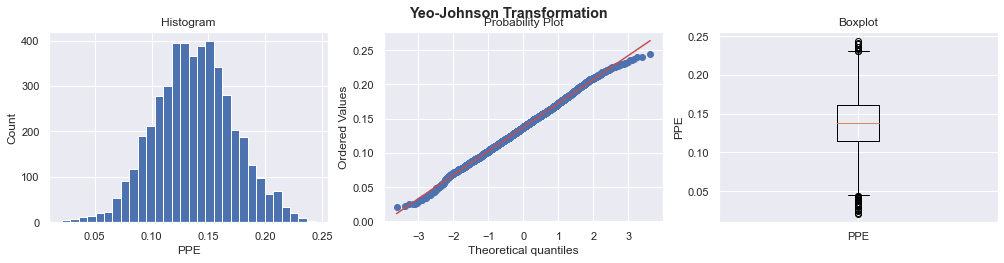

In [22]:
show_transformations(X_train,'PPE')

Yeo-Johnson transformation more closely lead to normal distriubtion of the variables. Thus, it was choosen to transform the selected variables.

In [23]:
# apply Yeo-Johnson transformation to the selected variables

def apply_powertranformation(df_train, df_test):
    cols_powertrans = [ 'Jitter(%)', 'Shimmer', 'HNR', 'PPE']
    cols_passthrough = [x for x in df_train.columns if x not in cols_powertrans]

    ct = make_column_transformer(
        (PowerTransformer(method='yeo-johnson', standardize=False), cols_powertrans),
        ('passthrough', cols_passthrough)
        )
    df_train = pd.DataFrame(ct.fit_transform(df_train), columns=cols_powertrans+cols_passthrough)
    df_test = pd.DataFrame(ct.transform(df_test), columns=cols_powertrans+cols_passthrough)

    return df_train, df_test

In [24]:
X_train, X_test = apply_powertranformation(X_train, X_test)

In [25]:
X_train.head()

,Jitter(%),Shimmer,HNR,PPE,age,sex,RPDE,DFA
0,0.003272,0.023492,104.904248,0.151167,75.0,0.0,0.59679,0.66536
1,0.002490,0.016193,139.366735,0.149120,66.0,1.0,0.50141,0.52669
2,0.005490,0.026269,91.935566,0.187950,66.0,0.0,0.72480,0.62491
3,0.004870,0.019435,139.673739,0.175641,58.0,0.0,0.55557,0.67689
4,0.003685,0.030932,100.330435,0.154615,49.0,0.0,0.56374,0.70793


## Feature Scaling

Models that are smooth functions of the input, such as linear regression, logistic regression, or anything that involves a matrix, are affected by the scale of the input. Tree-based models, on the other hand, couldn’t care less. If your model is sensitive to the scale of input features,
feature scaling could help. As the name suggests, feature scaling changes the scale of
the feature. Feature scaling is usually done individually to each feature. Feature scaling is useful in situations where a set of input features differs wildly in scale. Drastically varying scale in input features can lead to numeric stability issues for the model training algorithm. 

In [26]:
def apply_scaler(df_train, df_test):
    
    # Fit the scaler on the training data
    scaler = StandardScaler()
    scaler.fit(df_train)

    # Scale the training and test sets
    features = df_train.columns

    df_train[features] = scaler.transform(df_train[features])
    df_test[features] = scaler.transform(df_test[features])

    return df_train, df_test

In [27]:
X_train, X_test = apply_scaler(X_train, X_test)

In [28]:
X_train.head()

,Jitter(%),Shimmer,HNR,PPE,age,sex,RPDE,DFA
0,-0.053541,0.842130,-1.070886,0.387046,1.155188,-0.688007,0.546557,0.167585
1,-0.892954,-0.437505,-0.381782,0.328304,0.129529,1.453473,-0.401230,-1.779277
2,2.327828,1.328967,-1.330204,1.442642,0.129529,-0.688007,1.818586,-0.400314
3,1.662109,0.130838,-0.375643,1.089412,-0.782168,-0.688007,0.136955,0.329460
4,0.389353,2.146444,-1.162342,0.485999,-1.807827,-0.688007,0.218140,0.765248


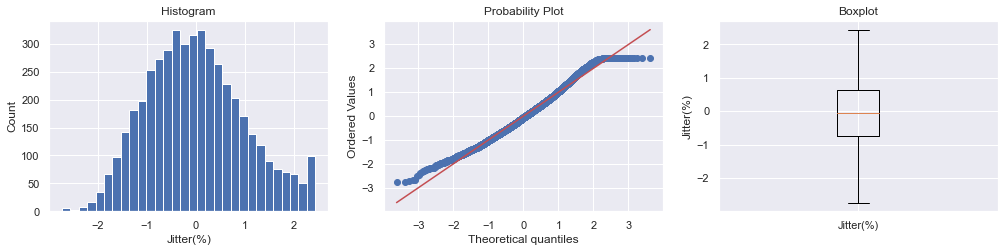

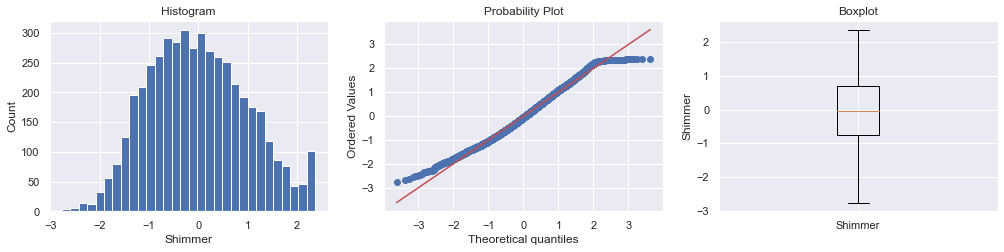

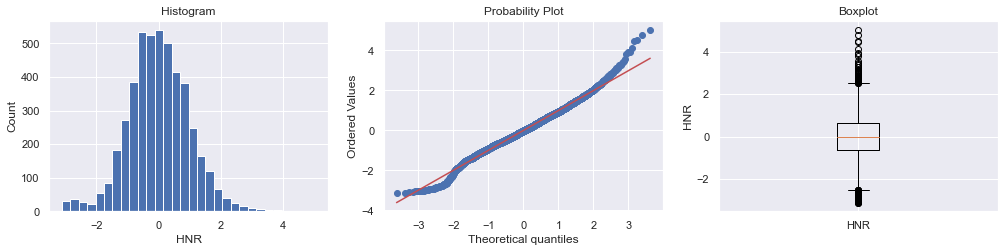

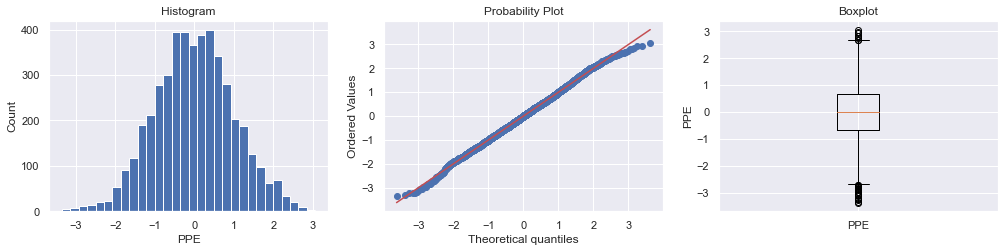

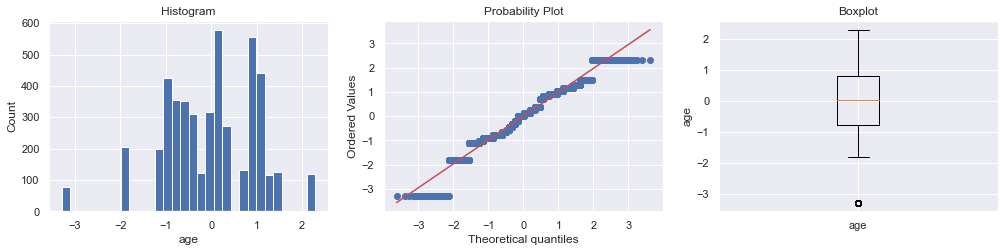

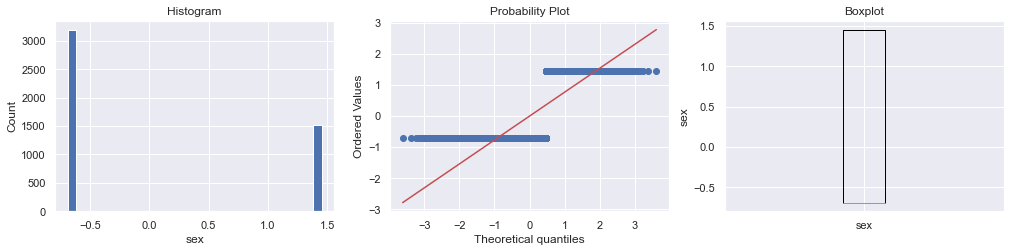

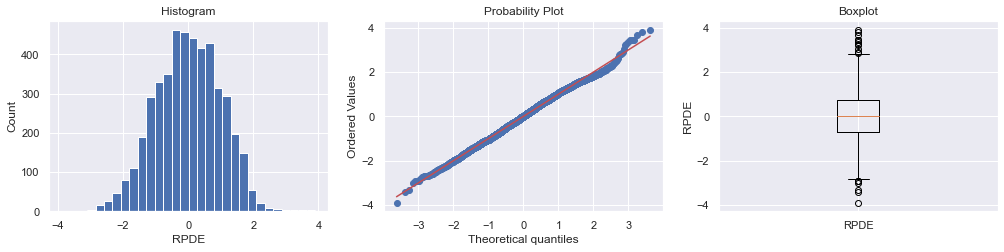

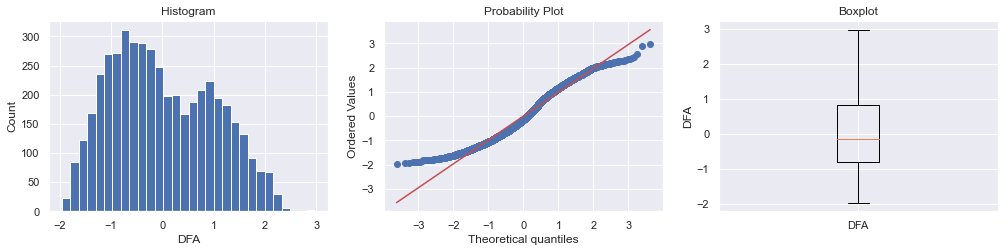

In [29]:
# Visualize all transformed features

for col in X_train.columns:
    diagnostic_plots(X_train[col], col)

# Training Models

Various predictive models are constructed. The hyperparameters of each models is optimized by various optimization techniques, such as random search and Bayesian optimization. 

In [30]:
# Dataframe to store scores

model_performance = pd.DataFrame({'Model':[], 'RMSE': [], 'r2': []})

def append_scores(dict_name, model_name, test_score):
    dict_name = dict_name.append({'Model': model_name, 'RMSE': test_score[0], 'r2': test_score[1]}, ignore_index=True)
    return dict_name


## Linear Regression

In [31]:
# define model
model = ElasticNet()

# hyperparameter space
param_grid = dict(
    alpha= stats.uniform(0, 10), 
    l1_ratio = stats.uniform(0, 1)
    )

# set up the search
search = RandomizedSearchCV(
    model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=400,
    random_state=10,
    n_jobs=-1,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=400, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022B249C52E0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022B249C5E50>},
                   random_state=10, scoring='neg_mean_squared_error')

{'alpha': 0.01759649104359773, 'l1_ratio': 0.9670457532300503}
-57.864156648575204


Text(0.5, 0, 'Hyperparameter combinations')

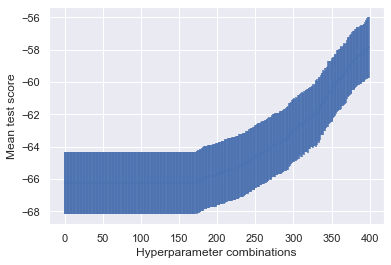

In [32]:
print(search.best_params_)
print(search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=True, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], 
                                      results['std_test_score']], subplots=True);
plt.ylabel('Mean test score'); plt.xlabel('Hyperparameter combinations')

In [33]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

model_performance = append_scores(model_performance, 'Linear Regression', 
                                  [mean_squared_error(y_test, X_test_preds)**0.5, 
                                   r2_score(y_test, X_test_preds)])

Train MSE:  57.71311502739155
Test MSE:  57.991143007336944
Train r2:  0.1289336929557039
Test r2:  0.11239188937730205


## Support Vector Regression


In [34]:
# model
model = SVR()

# determine the hyperparameter space
param_grid = [
  {'C': stats.uniform(0, 100), 'kernel': ['linear']},
  {'C': stats.uniform(0, 100), 'gamma': [1.0, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
 ]

# set up the search
search = RandomizedSearchCV(
    model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=50,
    random_state=10,
    n_jobs=-1,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022B26A4B070>,
                                         'kernel': ['linear']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022B26A4B820>,
                                         'gamma': [1.0, 0.1, 0.01, 0.001,
                                                   0.0001],
                                         'kernel': ['rbf']}],
                   random_state=10, scoring='neg_mean_squared_error')

{'C': 9.045934927090737, 'gamma': 1.0, 'kernel': 'rbf'}
-23.451989111615852


Text(0.5, 0, 'Hyperparameter combinations')

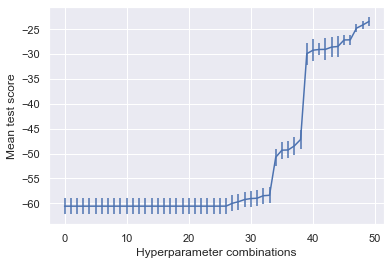

In [35]:
print(search.best_params_)
print(search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=True, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], 
                                      results['std_test_score']], subplots=True);
plt.ylabel('Mean test score'); plt.xlabel('Hyperparameter combinations')

In [36]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

model_performance = append_scores(model_performance, 'Support Vector', 
                                  [mean_squared_error(y_test, X_test_preds)**0.5, 
                                   r2_score(y_test, X_test_preds)])

Train MSE:  10.452023380449656
Test MSE:  22.698413024085877
Train r2:  0.8422472014753002
Test r2:  0.6525797828145325


## Decision Tree Regression

In [37]:
model = DecisionTreeRegressor(random_state=0)

# hyperparameter space
param_grid = {
    'min_samples_split': (0.001, 0.99, 'log-uniform'),
    'min_samples_leaf': (0.001, 0.5, 'log-uniform'),
    'max_depth': (1, 50),
    'max_leaf_nodes': (3, 500),    
    'max_features': ['auto', 'log2', 'sqrt', None],
    }

# set up the search
search = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=50,
    random_state=10,
    n_jobs=-1,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
              random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'max_depth': (1, 50),
                             'max_features': ['auto', 'log2', 'sqrt', None],
                             'max_leaf_nodes': (3, 500),
                             'min_samples_leaf': (0.001, 0.5, 'log-uniform'),
                             'min_samples_split': (0.001, 0.99, 'log-uniform')})

OrderedDict([('max_depth', 24), ('max_features', 'auto'), ('max_leaf_nodes', 190), ('min_samples_leaf', 0.001), ('min_samples_split', 0.0030672545971342415)])
-10.79452757433472


Text(0.5, 0, 'Hyperparameter combinations')

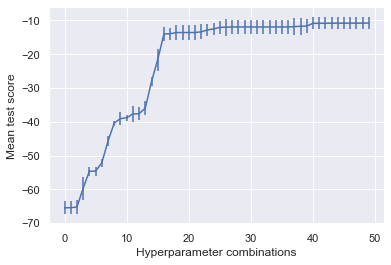

In [38]:
print(search.best_params_)
print(search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=True, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], 
                                      results['std_test_score']], subplots=True);
plt.ylabel('Mean test score'); plt.xlabel('Hyperparameter combinations')

In [39]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

model_performance = append_scores(model_performance, 'Decision Tree', 
                                  [mean_squared_error(y_test, X_test_preds)**0.5, 
                                   r2_score(y_test, X_test_preds)])

Train MSE:  4.769709362287114
Test MSE:  10.760343297196247
Train r2:  0.9280105896569586
Test r2:  0.8353029878637226


## Random Forest Regression

In [40]:
model = RandomForestRegressor(random_state=0)

# hyperparameter space
param_grid = {
    'n_estimators': (3, 300), 
    'min_samples_split': (0.001, 0.99, 'log-uniform'),
    'min_samples_leaf': (0.001, 0.5, 'log-uniform'),
    'max_leaf_nodes': (3, 500),
    'max_depth': (1, 50),
    'max_features': ['auto', 'log2', 'sqrt', None],
    }

# set up the search
search = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=50,
    random_state=10,
    n_jobs=-8,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-8,
              random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'max_depth': (1, 50),
                             'max_features': ['auto', 'log2', 'sqrt', None],
                             'max_leaf_nodes': (3, 500),
                             'min_samples_leaf': (0.001, 0.5, 'log-uniform'),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (3, 300)})

OrderedDict([('max_depth', 50), ('max_features', 'auto'), ('max_leaf_nodes', 186), ('min_samples_leaf', 0.001), ('min_samples_split', 0.001), ('n_estimators', 300)])
-7.247854591872755


Text(0.5, 0, 'Hyperparameter combinations')

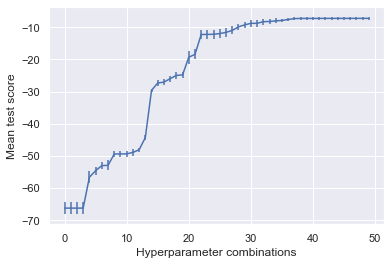

In [41]:
print(search.best_params_)
print(search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=True, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], 
                                      results['std_test_score']], subplots=True);
plt.ylabel('Mean test score'); plt.xlabel('Hyperparameter combinations')

In [42]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

model_performance = append_scores(model_performance, 'Random Forest', 
                                  [mean_squared_error(y_test, X_test_preds)**0.5, 
                                   r2_score(y_test, X_test_preds)])

Train MSE:  3.8526806282194106
Test MSE:  7.01674729858789
Train r2:  0.9418513402811233
Test r2:  0.8926021890682764


## Gradient Boosting Regression

In [43]:
model = GradientBoostingRegressor(random_state=0)

# hyperparameter space
param_grid = {
    'n_estimators': (5, 300), 
    'min_samples_split': (0.001, 0.99, 'log-uniform'),
    'min_samples_leaf': (0.001, 0.5, 'log-uniform'),
    'max_depth': (1, 50),
    'learning_rate': (0.001, 0.99, 'log-uniform'),
    'subsample': (0.001, 0.99, 'log-uniform'),
    'loss': ['ls', 'lad', 'huber'],
}

# set up the search
search = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=50,
    random_state=10,
    n_jobs=-1,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
              n_jobs=-1, random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'learning_rate': (0.001, 0.99, 'log-uniform'),
                             'loss': ['ls', 'lad', 'huber'],
                             'max_depth': (1, 50),
                             'min_samples_leaf': (0.001, 0.5, 'log-uniform'),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (5, 300),
                             'subsample': (0.001, 0.99, 'log-uniform')})

OrderedDict([('learning_rate', 0.25416943280622856), ('loss', 'huber'), ('max_depth', 37), ('min_samples_leaf', 0.009421864535520925), ('min_samples_split', 0.002436556066893352), ('n_estimators', 16), ('subsample', 0.99)])
-8.11119543320437


Text(0.5, 0, 'Hyperparameter combinations')

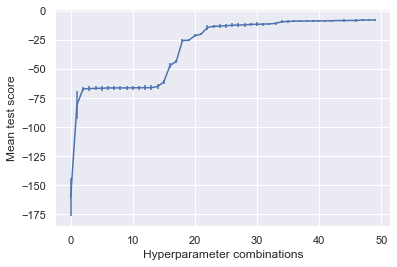

In [44]:
print(search.best_params_)
print(search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=True, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], 
                                      results['std_test_score']], subplots=True);
plt.ylabel('Mean test score'); plt.xlabel('Hyperparameter combinations')

In [45]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

model_performance = append_scores(model_performance, 'Gradient Boost', 
                                  [mean_squared_error(y_test, X_test_preds)**0.5, 
                                   r2_score(y_test, X_test_preds)])

Train MSE:  5.246177480639249
Test MSE:  8.524912429194169
Train r2:  0.9208192376725725
Test r2:  0.8695183260391393


## XGBoost Regression

In [46]:
model = XGBRegressor(random_state=0)

# hyperparameter space
param_grid = {
    'n_estimators': (3, 300), 
    'max_depth': (1, 50),
    'gamma': (0, 100),
    'reg_lambda': (0.001, 0.99, 'log-uniform'),
    'colsample_bytree' : (0.01, 1),
    'eta': (0.001, 0.99, 'log-uniform'),
    'subsample': (0.01, 1),
    'min_child_weight': (1, 40),
    'reg_alpha': (1e-5, 1e5, 'log-uniform'), 
    'learning_rate': (0.0001, 0.99, 'log-uniform'),
    }

# set up the search
search = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=50,
    random_state=10,
    n_jobs=-1,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
              n_jobs=-1, random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'colsample_bytree': (0.01, 1),
                             'eta': (0.001, 0.99, 'log-uniform'),
                             'gamma': (0, 100),
                             'le

OrderedDict([('colsample_bytree', 1.0), ('eta', 0.001), ('gamma', 35), ('learning_rate', 0.017268187975585474), ('max_depth', 50), ('min_child_weight', 35), ('n_estimators', 300), ('reg_alpha', 2.7675315803182325), ('reg_lambda', 0.001017871278916623), ('subsample', 0.8598205789524312)])
-7.81548093884829


Text(0.5, 0, 'Hyperparameter combinations')

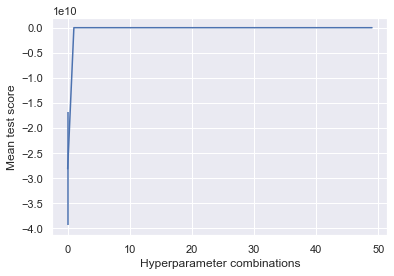

In [47]:
print(search.best_params_)
print(search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=True, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], 
                                      results['std_test_score']], subplots=True);
plt.ylabel('Mean test score'); plt.xlabel('Hyperparameter combinations')

In [48]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

model_performance = append_scores(model_performance, 'XGBoost', 
                                  [mean_squared_error(y_test, X_test_preds)**0.5, 
                                   r2_score(y_test, X_test_preds)])

Train MSE:  4.943783671139326
Test MSE:  7.825997422324282
Train r2:  0.9253832792910007
Test r2:  0.8802158670180288


## Neural Network Regression

In [49]:
def build_clf(unit1, unit2, unit3, activation1, activation2, activation3,
              lr_opt, dropout_rate1, dropout_rate2):
    # creating the layers of the NN
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(units=unit1, input_dim=X_train.shape[1], activation=activation1))
    ann.add(tf.keras.layers.Dropout(rate=dropout_rate1))
    ann.add(tf.keras.layers.Dense(units=unit2, activation=activation2))
    ann.add(tf.keras.layers.Dropout(rate=dropout_rate2))
    ann.add(tf.keras.layers.Dense(units=unit3, activation=activation3))
    ann.add(tf.keras.layers.Dense(units=1))
    
    ann.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=lr_opt))
    return ann

# Keras Regressor
model = KerasRegressor(build_fn=build_clf)

# hyperparameter space
param_grid = {
    'batch_size': (3, 100),
    'epochs': (30, 200),
    'unit1': (10, 400),
    'unit2': (10, 400),
    'unit3': (10, 400),
    'activation1': ['relu', 'tanh', 'linear', 'sigmoid'],
    'activation2': ['relu', 'tanh', 'linear', 'sigmoid'],
    'activation3': ['relu', 'tanh', 'linear', 'sigmoid'],
    'dropout_rate1': (0.0, 0.7),
    'dropout_rate2': (0.0, 0.7),
    'lr_opt': (1e-6, 1e3, 'log-uniform'),
    }

# set up the search
search = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=50,
    random_state=5,
    n_jobs=-1,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

Epoch 1/37
196/196 [==============================] - 0s 1ms/step - loss: 81.7078
Epoch 2/37
196/196 [==============================] - 0s 1ms/step - loss: 62.5818
Epoch 3/37
196/196 [==============================] - 0s 1ms/step - loss: 56.2664
Epoch 4/37
196/196 [==============================] - 0s 1ms/step - loss: 48.5756
Epoch 5/37
196/196 [==============================] - 0s 1ms/step - loss: 46.3746
Epoch 6/37
196/196 [==============================] - 0s 1ms/step - loss: 44.4320
Epoch 7/37
196/196 [==============================] - 0s 1ms/step - loss: 42.9758
Epoch 8/37
196/196 [==============================] - 0s 1ms/step - loss: 40.7152
Epoch 9/37
196/196 [==============================] - 0s 1ms/step - loss: 42.9422
Epoch 10/37
196/196 [==============================] - 0s 1ms/step - loss: 39.9489
Epoch 11/37
196/196 [==============================] - 0s 1ms/step - loss: 38.8363
Epoch 12/37
196/196 [==============================] - 0s 1ms/step - loss: 38.0894
Epoch 13/37
1

BayesSearchCV(cv=3,
              estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000022B2719A730>,
              n_jobs=-1, random_state=5, scoring='neg_mean_squared_error',
              search_spaces={'activation1': ['relu', 'tanh', 'linear',
                                             'sigmoid'],
                             'activation2': ['relu', 'tanh', 'linear',
                                             'sigmoid'],
                             'activation3': ['relu', 'tanh', 'linear',
                                             'sigmoid'],
                             'batch_size': (3, 100),
                             'dropout_rate1': (0.0, 0.7),
                             'dropout_rate2': (0.0, 0.7), 'epochs': (30, 200),
                             'lr_opt': (0.0001, 0.99, 'log-uniform'),
                             'unit1': (10, 400), 'unit2': (10, 400),
                             'unit3': (10, 400)})

OrderedDict([('activation1', 'tanh'), ('activation2', 'sigmoid'), ('activation3', 'relu'), ('batch_size', 24), ('dropout_rate1', 0.3551082937116239), ('dropout_rate2', 0.7), ('epochs', 37), ('lr_opt', 0.020385930001941548), ('unit1', 43), ('unit2', 100), ('unit3', 216)])
-27.41046388059039


Text(0.5, 0, 'Hyperparameter combinations')

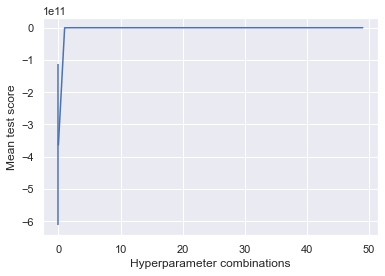

In [50]:
print(search.best_params_)
print(search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=True, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], 
                                      results['std_test_score']], subplots=True);
plt.ylabel('Mean test score'); plt.xlabel('Hyperparameter combinations')

In [51]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

model_performance = append_scores(model_performance, 'Neural Network', 
                                  [mean_squared_error(y_test, X_test_preds)**0.5, 
                                   r2_score(y_test, X_test_preds)])

Train MSE:  23.707965268652398
Test MSE:  25.681080059482962
Train r2:  0.642174751019797
Test r2:  0.6069273035804112


In [52]:
model_performance.sort_values('RMSE', ascending  = True)

,Model,RMSE,r2
3,Random Forest,2.648914,0.892602
5,XGBoost,2.797498,0.880216
4,Gradient Boost,2.919745,0.869518
2,Decision Tree,3.280296,0.835303
1,Support Vector,4.764285,0.652580
6,Neural Network,5.067650,0.606927
0,Linear Regression,7.615192,0.112392


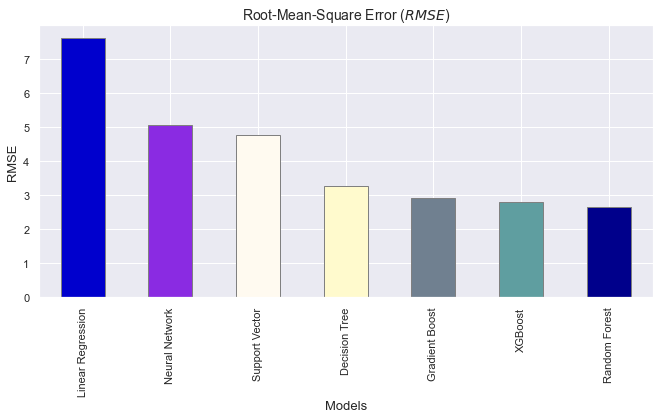

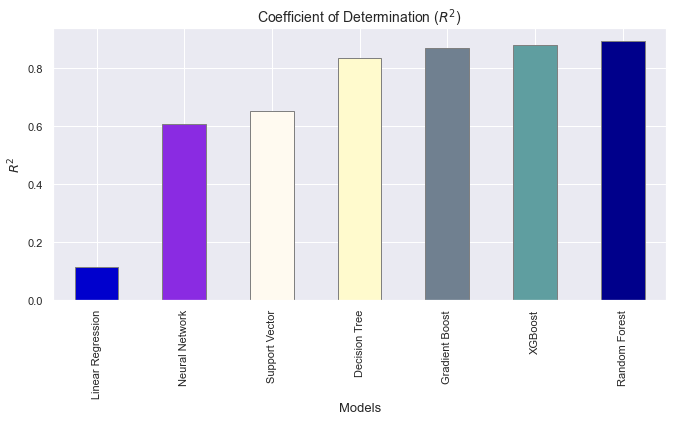

In [55]:
all_colors = list(plt.cm.colors.cnames.keys())
c = random.choices(all_colors, k=model_performance['RMSE'].unique().__len__()+1)
model_performance.sort_values('RMSE', ascending  = False).plot(x='Model', y='RMSE', kind='bar', color=c,
                                                             edgecolor = 'gray', figsize=(11,5));
plt.ylabel('RMSE', size=13); plt.xlabel('Models', size=13); plt.legend().set_visible(False);
plt.title('Root-Mean-Square Error ($RMSE$)', size=14);
plt.show()

model_performance.sort_values('r2', ascending  = True).plot(x='Model', y='r2', kind='bar', color=c,
                                                             edgecolor = 'gray', figsize=(11,5));
plt.ylabel('$R^2$', size=13); plt.xlabel('Models', size=13); plt.legend().set_visible(False);
plt.title('Coefficient of Determination ($R^2$)', size=14);
plt.show()

In [77]:
def percentage_difference(v1,v2):
    return (abs(v1-v2)/((v1+v2)/2))*100

model_performance['difference'] = model_performance.apply(lambda row: percentage_difference(
    model_performance['RMSE'][0], row['RMSE']), axis=1)
model_performance.sort_values('difference', ascending = True)

,Model,RMSE,r2,difference
0,Linear Regression,7.615192,0.112392,0.000000
6,Neural Network,5.067650,0.606927,40.173035
1,Support Vector,4.764285,0.652580,46.058594
2,Decision Tree,3.280296,0.835303,79.572305
4,Gradient Boost,2.919745,0.869518,89.140474
5,XGBoost,2.797498,0.880216,92.535035
3,Random Forest,2.648914,0.892602,96.769797


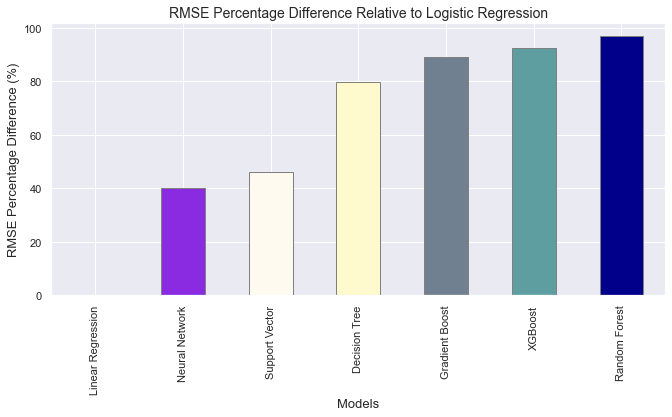

In [74]:
model_performance.sort_values('difference', ascending  = True).plot(x='Model', y='difference', kind='bar', 
                                                                    color=c, edgecolor = 'gray', 
                                                                    figsize=(11,5));
plt.ylabel('RMSE Percentage Difference (%)', size=13); plt.xlabel('Models', size=13); 
plt.legend().set_visible(False);
plt.title('RMSE Percentage Difference Relative to Logistic Regression', size=14);
plt.show()

## Conclusions


The results show that the logistic regression model had the highest root-mean-square error (RMSE) and the random forest had the lowest RMSE. The RMSE of random forest, XBGboost, and gradient boost were similar and compared to logistic regression, their percentage differences were over 80%.  

